In [1]:
# Basic setup
!pip install -q tensorflow matplotlib pandas scikit-learn

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model


import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc,classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
pip install rarfile

In [3]:
# Unzip your image datasets
for zip_file in ['train.zip', 'val.zip', 'test.zip']:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(os.path.splitext(zip_file)[0])


In [ ]:
# import zipfile
# import gdown
# import os

# # Replace with your actual public Google Drive link (use uc?id= format)
# drive_url = 'https://drive.google.com/file/d/1Rp5e7KHV-x1pd6-MyY72OEFqbXtZ7ERm/view?usp=sharing'

# zip_filename = 'split.zip'

# # Step 1: Download the ZIP file
# print("⬇Downloading ZIP file...")
# gdown.download(drive_url, zip_filename, quiet=False)

# # Step 2: Unzip directly into current directory (no new folder)
# print("Extracting ZIP...")
# with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
#     zip_ref.extractall()  # extract to current working directory

# print("✅ Done! Files extracted here:", os.getcwd())


In [4]:
# Load metadata CSVs
train_meta = pd.read_csv('metadata/train_augmented_metadata.csv')
val_meta = pd.read_csv('metadata/val_metadata.csv')
test_meta = pd.read_csv('metadata/test_metadata.csv')

train_meta.head()


,photo_id,business_id,caption,label
0,--DqlLaO1I0D7uFgvRInww_aug,0wRkPZNnBEHMqHGqMfdIYA,They renovated the Taco Bell! It's the little...,outside
1,-03jEudW-0CXZhRhY9j3cg_aug,2C1woaOBpUC2iEpvKx96gg,NaN,drink
2,-194bfBI_zM5ELv-mizqvA_aug,Tf_Oj8uWRvXmqkEmntzTdA,NaN,inside
3,-174ci6bCbX7-D0khhO7hg_aug,DKJrr6qa4mzeyJTBCA2Sqw,Italian Hoagie,food
4,--IHD2ZgFPfFMR4qMkLzFA_aug,3qpubK1C8SsDcq8BeKOEbA,Hidden in the rear is this oasis-like beer gar...,outside


In [5]:
import os
import pandas as pd
from shutil import copy2

def organize_images(csv_path, image_dir, output_dir):
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        photo_id = str(row['photo_id'])
        label = str(row['label'])

        # Source image path (your unzipped image dir will be "train/train", "val/val", etc.)
        src_path = os.path.join(image_dir, f"{photo_id}.jpg")

        # Destination path: data_sorted/train/label/photo_id.jpg
        dst_folder = os.path.join(output_dir, label)
        dst_path = os.path.join(dst_folder, f"{photo_id}.jpg")

        os.makedirs(dst_folder, exist_ok=True)

        if os.path.exists(src_path):
            copy2(src_path, dst_path)
        else:
            print(f"WARNING: {src_path} not found!")

# Root folder where your unzipped data is (train/, val/, test/)
image_root = ""

# Paths to metadata files
meta_paths = {
    'train': 'metadata/train_augmented_metadata.csv',
    'val': 'metadata/val_metadata.csv',
    'test': 'metadata/test_metadata.csv'
}

# Process each split
for split, csv_file in meta_paths.items():
    print(f"Processing {split} set...")

    image_dir = os.path.join(split, split)  # 'train/train', 'val/val', 'test/test'
    output_dir = os.path.join("data_sorted", split)

    organize_images(
        csv_path=csv_file,
        image_dir=image_dir,
        output_dir=output_dir
    )

print("✅ Done organizing all splits.")


Processing train set...
Processing val set...
Processing test set...
✅ Done organizing all splits.


In [6]:
for root, dirs, files in os.walk("data_sorted/train"):
    print(f"{root} - {len(files)} files")


data_sorted/train - 0 files
data_sorted/train/outside - 4001 files
data_sorted/train/drink - 3971 files
data_sorted/train/food - 4006 files
data_sorted/train/menu - 1191 files
data_sorted/train/inside - 4023 files


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 32

# Image generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'data_sorted/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data_sorted/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 17192 images belonging to 5 classes.
Found 2146 images belonging to 5 classes.


In [8]:
# Load train and validation metadata
train_meta = pd.read_csv("metadata/train_augmented_metadata.csv")
val_meta = pd.read_csv("metadata/val_metadata.csv")

train_meta.head()

,photo_id,business_id,caption,label
0,--DqlLaO1I0D7uFgvRInww_aug,0wRkPZNnBEHMqHGqMfdIYA,They renovated the Taco Bell! It's the little...,outside
1,-03jEudW-0CXZhRhY9j3cg_aug,2C1woaOBpUC2iEpvKx96gg,NaN,drink
2,-194bfBI_zM5ELv-mizqvA_aug,Tf_Oj8uWRvXmqkEmntzTdA,NaN,inside
3,-174ci6bCbX7-D0khhO7hg_aug,DKJrr6qa4mzeyJTBCA2Sqw,Italian Hoagie,food
4,--IHD2ZgFPfFMR4qMkLzFA_aug,3qpubK1C8SsDcq8BeKOEbA,Hidden in the rear is this oasis-like beer gar...,outside


In [ ]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17192 entries, 0 to 17191
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   photo_id     17192 non-null  object
 1   business_id  17192 non-null  object
 2   caption      8227 non-null   object
 3   label        17192 non-null  object
dtypes: object(4)
memory usage: 537.4+ KB


In [9]:
# Handle missing values in caption → replace NaN with empty string
train_meta['caption'] = train_meta['caption'].fillna('')
val_meta['caption'] = val_meta['caption'].fillna('')

# Feature 1: Length of caption (number of characters)
train_meta['caption_length'] = train_meta['caption'].apply(len)
val_meta['caption_length'] = val_meta['caption'].apply(len)

# Feature 2: Number of words in caption
train_meta['caption_word_count'] = train_meta['caption'].apply(lambda x: len(x.split()))
val_meta['caption_word_count'] = val_meta['caption'].apply(lambda x: len(x.split()))

# Check result
train_meta[['caption', 'caption_length', 'caption_word_count']].head()


,caption,caption_length,caption_word_count
0,They renovated the Taco Bell! It's the little...,62,11
1,,0,0
2,,0,0
3,Italian Hoagie,14,2
4,Hidden in the rear is this oasis-like beer gar...,65,12


# VGG custom model-1 with added features

1. Metadata Features added - caption length and word count
2. caption length can be less for items like food and drink and can be longer or descriptive for classes like Menu, outside and inside which will provide more information to model to classify classes accurately, same for word count as well.

In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence
import os

class ImageMetadataGenerator(Sequence):
    def __init__(self, image_generator, metadata_df, batch_size, image_dir, **kwargs):
        super().__init__(**kwargs)
        self.image_generator = image_generator
        self.metadata_df = metadata_df
        self.batch_size = batch_size
        self.image_dir = image_dir

        # Create metadata map → maps filename → (caption_length, caption_word_count)
        self.metadata_map = self._prepare_metadata_map()

    def _prepare_metadata_map(self):
        mapping = {}
        for i, row in self.metadata_df.iterrows():
            filename = row['photo_id'] + ".jpg"
            mapping[filename] = np.array([
                row['caption_length'],
                row['caption_word_count']
            ], dtype='float32')
        return mapping

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images, labels = self.image_generator[index]
        metadata_batch = []

        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_generator.filenames))
        batch_filenames = [
            os.path.basename(self.image_generator.filenames[i])
            for i in range(start_idx, end_idx)
        ]

        for fname in batch_filenames:
            meta_vec = self.metadata_map.get(fname, np.zeros(2))  # default to [0,0] if missing
            metadata_batch.append(meta_vec)

        return (images, np.array(metadata_batch)), labels


In [11]:
# Initialize train metadata generator
train_meta_gen = ImageMetadataGenerator(
    image_generator=train_gen,
    metadata_df=train_meta,
    batch_size=batch_size,
    image_dir='data_sorted/train'
)

# Initialize validation metadata generator
val_meta_gen = ImageMetadataGenerator(
    image_generator=val_gen,
    metadata_df=val_meta,
    batch_size=batch_size,
    image_dir='data_sorted/val'
)


In [12]:
# Load test metadata
test_meta = pd.read_csv("metadata/test_metadata.csv")
test_meta['caption'] = test_meta['caption'].fillna('')
test_meta['caption_length'] = test_meta['caption'].apply(len)
test_meta['caption_word_count'] = test_meta['caption'].apply(lambda x: len(x.split()))

# Prepare test image generator
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data_sorted/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # do not shuffle!
)

# Wrap in ImageMetadataGenerator
test_meta_gen = ImageMetadataGenerator(
    image_generator=test_gen,
    metadata_df=test_meta,
    batch_size=batch_size,
    image_dir='data_sorted/test'
)


Found 2149 images belonging to 5 classes.


In [13]:
vgg_full = VGG16(weights='imagenet', include_top=True)
vgg_full.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

# Phase 1 - Feature extraction and Training only meta data first by freezing all layers.

In [14]:


# Image input
image_input = Input(shape=(128, 128, 3), name='image_input')

# VGG16 base model (exclude top layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

# Freeze VGG16 layers (feature extraction phase!)
for layer in vgg_base.layers:
    layer.trainable = False

# Flatten VGG16 output
x = Flatten()(vgg_base.output)

# Metadata input (caption_length, caption_word_count → 2D input)
metadata_input = Input(shape=(2,), name='metadata_input')

# Small Dense layer for metadata (you can tune this size if you want)
metadata_dense = Dense(16, activation='relu')(metadata_input)

# Combine image and metadata features
combined = Concatenate()([x, metadata_dense])

# Dense layers on top
combined = Dense(256, activation='relu')(combined)
combined = Dense(128, activation='relu')(combined)

# Final output layer → 5 classes (softmax)
output = Dense(5, activation='softmax')(combined)

# Final model
model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,849,781 (64.28 MB)

 Trainable params: 2,135,093 (8.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
#
steps_per_epoch = len(train_meta_gen)
validation_steps = len(val_meta_gen)


history = model.fit(
    train_meta_gen,
    validation_data=val_meta_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    verbose=1
)


Epoch 1/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.7154 - loss: 0.7441 - val_accuracy: 0.8267 - val_loss: 0.4642
Epoch 2/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.8579 - loss: 0.3837 - val_accuracy: 0.7917 - val_loss: 0.5517
Epoch 3/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8826 - loss: 0.3055 - val_accuracy: 0.8364 - val_loss: 0.4592
Epoch 4/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.9164 - loss: 0.2260 - val_accuracy: 0.8225 - val_loss: 0.5910
Epoch 5/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - accuracy: 0.9370 - loss: 0.1755 - val_accuracy: 0.8360 - val_loss: 0.5305
Epoch 6/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.9486 - loss: 0.1395 - val_accuracy: 0.8183 - val_loss: 0.7136
Epoch 7/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9651 - loss: 0.0965 - val_accuracy: 0.8215 - val_loss: 0.7870
Epoch 8/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.9735 - loss: 0.0719 - 

#"fine-tuning the entire model"


In [16]:
# "fine-tuning the entire model"

from tensorflow.keras.optimizers import Adam

for layer in vgg_base.layers:
    layer.trainable = True

# Re-compile with low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lower LR is very important here
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: check which layers are now trainable
print("Trainable layers:")
for layer in model.layers:
    print(layer.name, layer.trainable)


model.summary()



Trainable layers:
image_input True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
metadata_input True
flatten True
dense True
concatenate True
dense_1 True
dense_2 True
dense_3 True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,849,781 (64.28 MB)

 Trainable params: 16,849,781 (64.28 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train again (fine-tuning phase)
history_finetune = model.fit(
    train_meta_gen,
    validation_data=val_meta_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,  # adjust as needed
    verbose=1
)

Epoch 1/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 128s 199ms/step - accuracy: 0.9709 - loss: 0.0795 - val_accuracy: 0.8350 - val_loss: 0.8960
Epoch 2/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 98s 182ms/step - accuracy: 0.9879 - loss: 0.0359 - val_accuracy: 0.8369 - val_loss: 0.8397
Epoch 3/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9858 - loss: 0.0406 - val_accuracy: 0.8411 - val_loss: 0.8625
Epoch 4/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 98s 182ms/step - accuracy: 0.9914 - loss: 0.0261 - val_accuracy: 0.8472 - val_loss: 0.8131
Epoch 5/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9951 - loss: 0.0151 - val_accuracy: 0.8607 - val_loss: 0.7789
Epoch 6/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9963 - loss: 0.0135 - val_accuracy: 0.8588 - val_loss: 0.8385
Epoch 7/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9899 - loss: 0.0293 - val_accuracy: 0.8495 - val_loss: 0.8681
Epoch 8/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9960 - l

In [ ]:
model.save('VGG16_with_metadata1.keras')

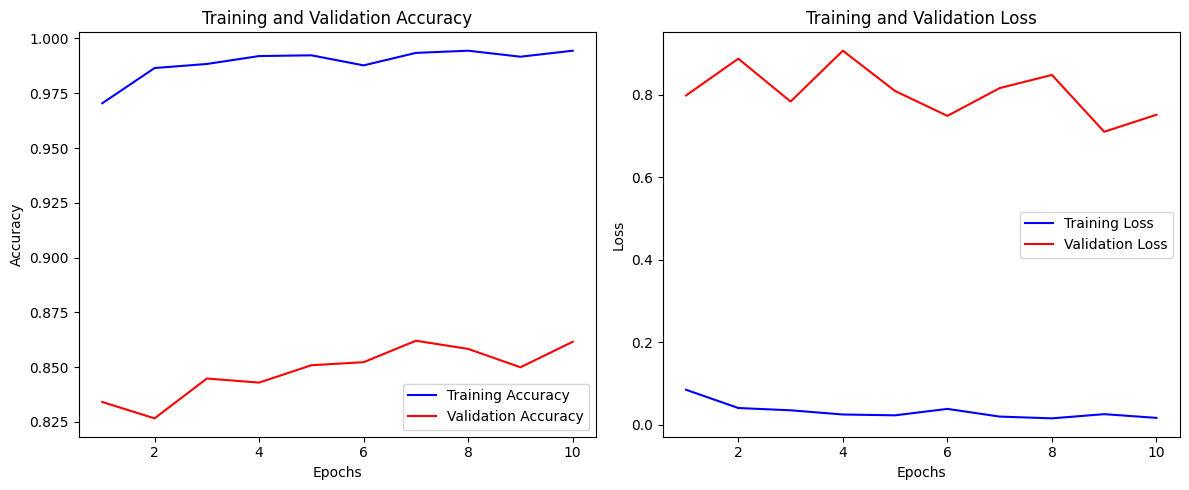

In [ ]:
import matplotlib.pyplot as plt


acc     = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss     = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs   = range(1, len(acc) + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
def evaluate_model(model, test_gen, num_classes=5, class_names=None):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

    # Auto extract class_names from generator if not provided
    if class_names is None:
        if hasattr(test_gen, 'class_indices'):
            class_names = list(test_gen.class_indices.keys())
            print(f"[INFO] Auto-detected class names: {class_names}")
        elif hasattr(test_gen, 'image_generator') and hasattr(test_gen.image_generator, 'class_indices'):
            class_names = list(test_gen.image_generator.class_indices.keys())
            print(f"[INFO] Auto-detected class names from image_generator: {class_names}")
        else:
            print("[WARNING] Could not auto-detect class names.")



    # Get number of test steps
    steps = len(test_gen)

    # Collect all predictions and labels
    y_true = []
    y_pred_probs = []

    for i in range(steps):
        (images, metadata), labels = test_gen[i]

        # Predict probabilities
        preds = model.predict([images, metadata], verbose=0)
        y_pred_probs.extend(preds)
        y_true.extend(labels)

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Convert one-hot labels to class indices
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    acc = accuracy_score(y_true_classes, y_pred_classes)
    print(f'Accuracy: {acc:.4f}')

    # AUC (One-vs-Rest)
    try:
        auc_score = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
        print(f'AUC (OvR): {auc_score:.4f}')
    except Exception as e:
        print("AUC calculation failed:", e)
        auc_score = None

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names if class_names else None))

    # Plot ROC curves (one vs rest)
    plt.figure(figsize=(10,8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i] if class_names else i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Return metrics
    return {
        'accuracy': acc,
        'auc': auc_score,
        'confusion_matrix': cm
    }


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.8551
AUC (OvR): 0.9786


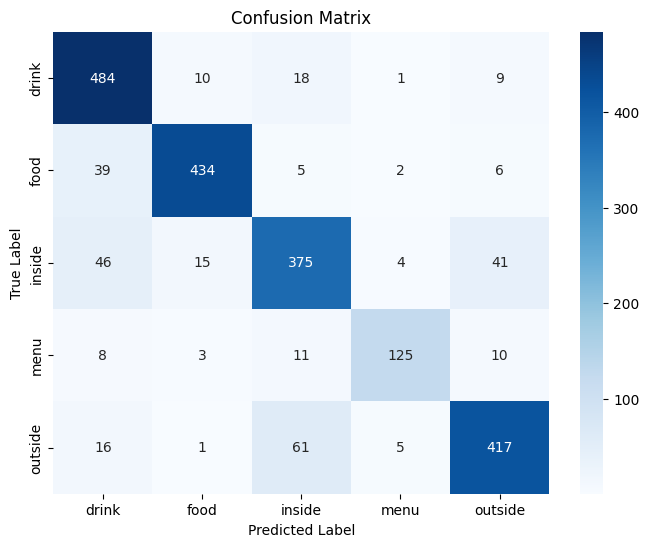

Classification Report:
              precision    recall  f1-score   support

       drink       0.82      0.93      0.87       522
        food       0.94      0.89      0.91       486
      inside       0.80      0.78      0.79       481
        menu       0.91      0.80      0.85       157
     outside       0.86      0.83      0.85       500

    accuracy                           0.86      2146
   macro avg       0.87      0.85      0.85      2146
weighted avg       0.86      0.86      0.85      2146



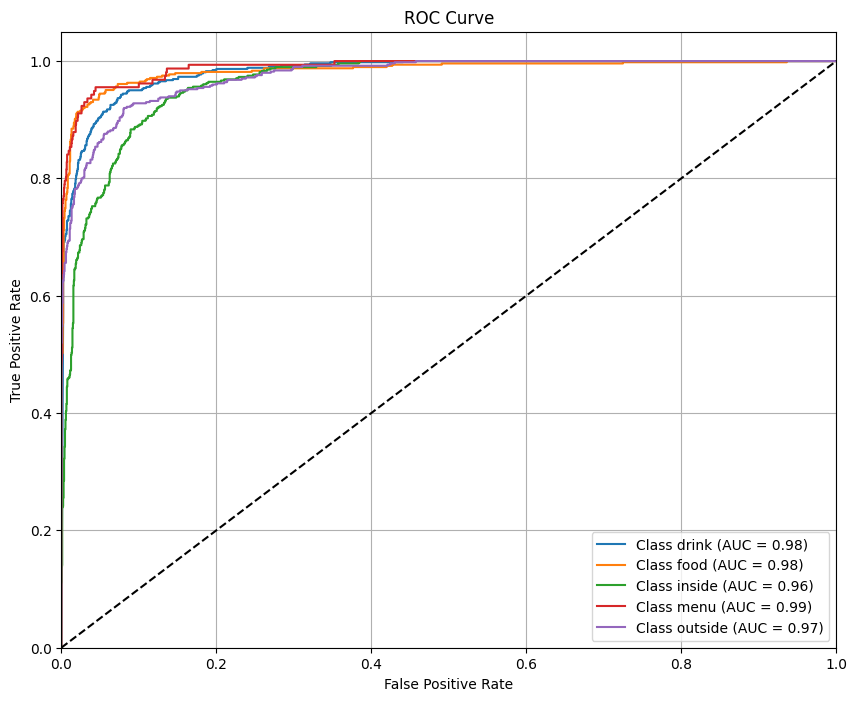

In [19]:

metrics = evaluate_model(model, val_meta_gen, num_classes=5)


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9951
AUC (OvR): 1.0000


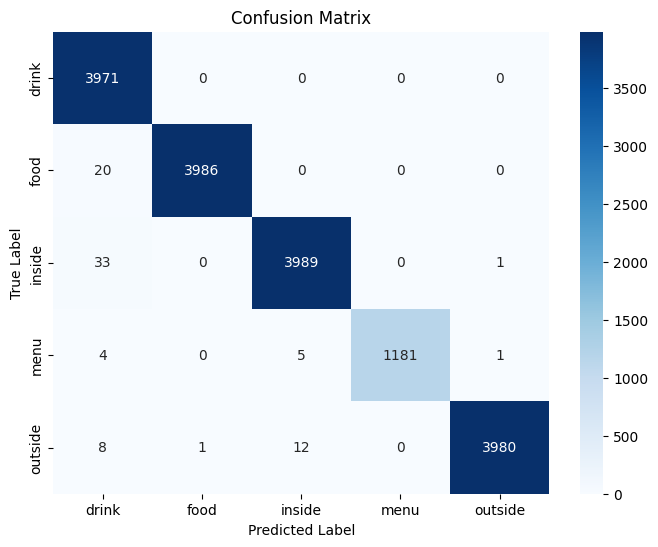

Classification Report:
              precision    recall  f1-score   support

       drink       0.98      1.00      0.99      3971
        food       1.00      1.00      1.00      4006
      inside       1.00      0.99      0.99      4023
        menu       1.00      0.99      1.00      1191
     outside       1.00      0.99      1.00      4001

    accuracy                           1.00     17192
   macro avg       1.00      0.99      1.00     17192
weighted avg       1.00      1.00      1.00     17192



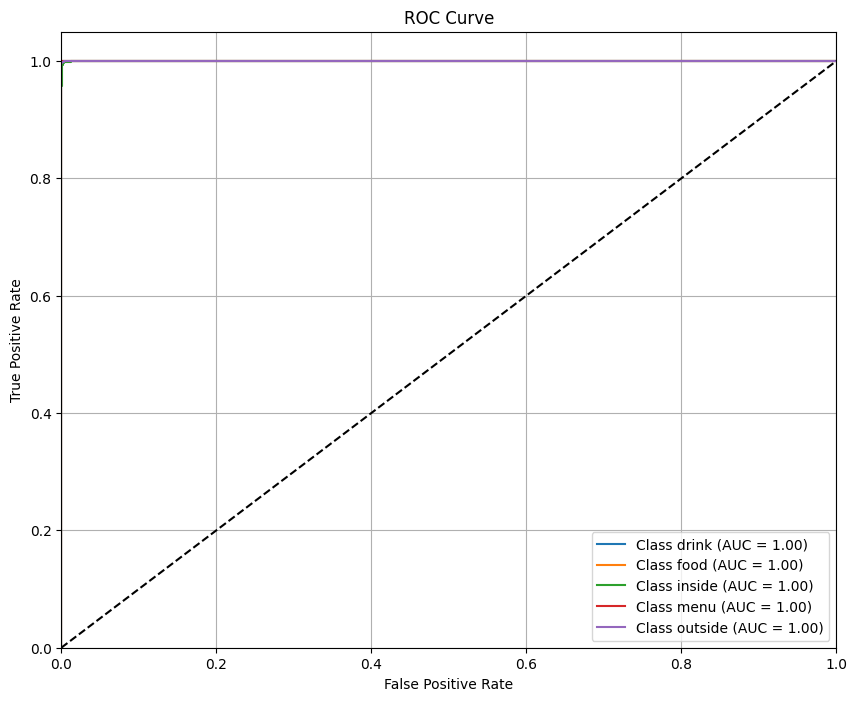

In [23]:
metrics = evaluate_model(model, train_meta_gen, num_classes=5)

# Function to track Results

In [20]:

results_df = pd.DataFrame(columns=['Model', 'Data Type', 'Accuracy', 'AUC'])


def log_model_results(model_name, data_type, accuracy, auc_score):
    global results_df
    new_entry = {
        'Model': model_name,
        'Data Type': data_type,
        'Accuracy': accuracy,
        'AUC': auc_score
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
    print(f"[INFO] Logged results for {model_name} ({data_type})")


In [24]:
log_model_results(
    model_name = 'VGG16 + metadata (fine-tuned)',
    data_type = 'Training',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)


[INFO] Logged results for VGG16 + metadata (fine-tuned) (Training)


In [25]:
results_df

,Model,Data Type,Accuracy,AUC
0,VGG16 + metadata (fine-tuned),Validation,0.855079,0.978648
1,VGG16 + metadata (fine-tuned),Training,0.995056,0.999986


# Model Tuning 1

- Full fine-tuning of VGG16 model (all layers trainable).
- Added metadata features: 100D TF-IDF embedding reduced to 16D via PCA.
- Applied Dropout 0.5 and L2 regularization (1e-4) to dense layers.
- Used dense architecture: 256→128 neurons with dropout between layers.
- Applied early stopping (patience=3) and low learning rate (1e-5).

In [26]:
import re

def preprocess_caption(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply preprocessing
train_meta['caption'] = train_meta['caption'].fillna('').apply(preprocess_caption)
val_meta['caption'] = val_meta['caption'].fillna('').apply(preprocess_caption)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Create TF-IDF vectorizer with 100 features
tfidf = TfidfVectorizer(max_features=100)

# Fit TF-IDF on training captions
tfidf_vectors_train = tfidf.fit_transform(train_meta['caption']).toarray()

# Reduce dimensionality from 100D to 16D using PCA
pca = PCA(n_components=16, random_state=42)
tfidf_vectors_train_pca = pca.fit_transform(tfidf_vectors_train)

# Add TF-IDF features to training metadata
for i in range(16):
    train_meta[f'tfidf_{i}'] = tfidf_vectors_train_pca[:, i]

# Transform validation captions using fitted vectorizer and PCA
tfidf_vectors_val = tfidf.transform(val_meta['caption']).toarray()
tfidf_vectors_val_pca = pca.transform(tfidf_vectors_val)
for i in range(16):
    val_meta[f'tfidf_{i}'] = tfidf_vectors_val_pca[:, i]

In [28]:
import numpy as np
from tensorflow.keras.utils import Sequence
import os

class ImageMetadataGenerator(Sequence):
    def __init__(self, image_generator, metadata_df, batch_size, image_dir, **kwargs):
        super().__init__(**kwargs)
        self.image_generator = image_generator
        self.metadata_df = metadata_df
        self.batch_size = batch_size
        self.image_dir = image_dir

        # Create metadata mapping from filename to TF-IDF features
        self.metadata_map = self._prepare_metadata_map()

    def _prepare_metadata_map(self):
        mapping = {}
        # Extract TF-IDF feature columns from metadata dataframe
        tfidf_features = self.metadata_df[[f'tfidf_{i}' for i in range(16)]].values

        # Map each filename to its corresponding TF-IDF vector
        for i, row in self.metadata_df.iterrows():
            filename = row['photo_id'] + ".jpg"
            mapping[filename] = tfidf_features[i]
        return mapping

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images, labels = self.image_generator[index]
        metadata_batch = []

        # Calculate batch indices for filenames
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_generator.filenames))
        batch_filenames = [
            os.path.basename(self.image_generator.filenames[i])
            for i in range(start_idx, end_idx)
        ]

        # Get metadata features for each image in batch
        for fname in batch_filenames:
            meta_vec = self.metadata_map.get(fname, np.zeros(16))  # default to 16D zero vector if missing
            metadata_batch.append(meta_vec)

        return (images, np.array(metadata_batch)), labels

In [29]:
# Initialize train metadata generator
train_meta_gen = ImageMetadataGenerator(
    image_generator=train_gen,
    metadata_df=train_meta,
    batch_size=batch_size,
    image_dir='data_sorted/train'
)

# Initialize validation metadata generator
val_meta_gen = ImageMetadataGenerator(
    image_generator=val_gen,
    metadata_df=val_meta,
    batch_size=batch_size,
    image_dir='data_sorted/val'
)


In [32]:
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 # Import l2 regularizer

# Define image input layer
image_input = Input(shape=(128, 128, 3), name='image_input')

# Load VGG16 base model without top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
x = Flatten()(vgg_base.output)

# Make all VGG16 layers trainable for fine-tuning
for layer in vgg_base.layers:
    layer.trainable = True

# Define metadata input for 16D TF-IDF features
metadata_input = Input(shape=(16,), name='metadata_input')

# Concatenate image and metadata features
combined = Concatenate()([x, metadata_input])

# Add dense layers with Dropout and L2 regularization
combined = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(combined)
combined = Dropout(0.5)(combined)

combined = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(combined)
combined = Dropout(0.5)(combined)

# Add output layer for 5 classes
output = Dense(5, activation='softmax')(combined)

# Create final model with dual inputs
model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile model with low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,849,733 (64.28 MB)

 Trainable params: 16,849,733 (64.28 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with early stopping callback
history_iter1 = model.fit(
    train_meta_gen,
    validation_data=val_meta_gen,
    steps_per_epoch=len(train_meta_gen),
    validation_steps=len(val_meta_gen),
    callbacks=[early_stop],
    epochs=15,
    verbose=1
)

Epoch 1/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 114s 194ms/step - accuracy: 0.4608 - loss: 1.3781 - val_accuracy: 0.8253 - val_loss: 0.5427
Epoch 2/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.7933 - loss: 0.6410 - val_accuracy: 0.8779 - val_loss: 0.4178
Epoch 3/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 183ms/step - accuracy: 0.8556 - loss: 0.4954 - val_accuracy: 0.8812 - val_loss: 0.4029
Epoch 4/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.8840 - loss: 0.4015 - val_accuracy: 0.8826 - val_loss: 0.4025
Epoch 5/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.9050 - loss: 0.3504 - val_accuracy: 0.8747 - val_loss: 0.4326
Epoch 6/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 183ms/step - accuracy: 0.9163 - loss: 0.3176 - val_accuracy: 0.8956 - val_loss: 0.3963
Epoch 7/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 184ms/step - accuracy: 0.9321 - loss: 0.2673 - val_accuracy: 0.9049 - val_loss: 0.3640
Epoch 8/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 184ms/step - accuracy: 0.9436 - loss

In [ ]:
model.save('VGG16_with_metadata2.keras')

[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9668
AUC (OvR): 0.9985


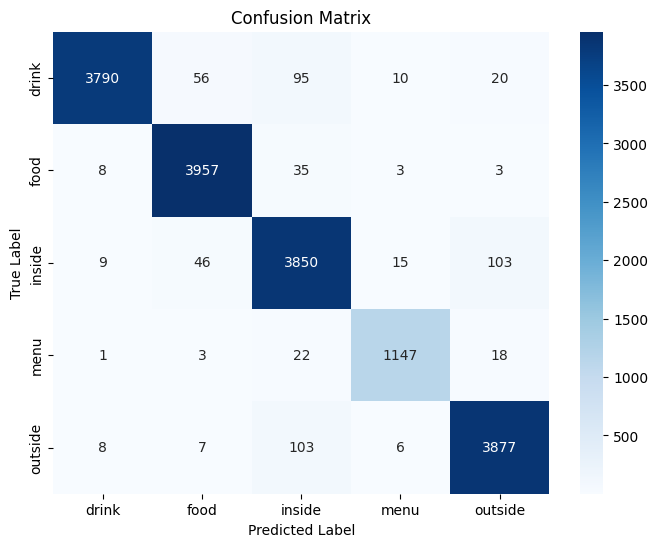

Classification Report:
              precision    recall  f1-score   support

       drink       0.99      0.95      0.97      3971
        food       0.97      0.99      0.98      4006
      inside       0.94      0.96      0.95      4023
        menu       0.97      0.96      0.97      1191
     outside       0.96      0.97      0.97      4001

    accuracy                           0.97     17192
   macro avg       0.97      0.97      0.97     17192
weighted avg       0.97      0.97      0.97     17192



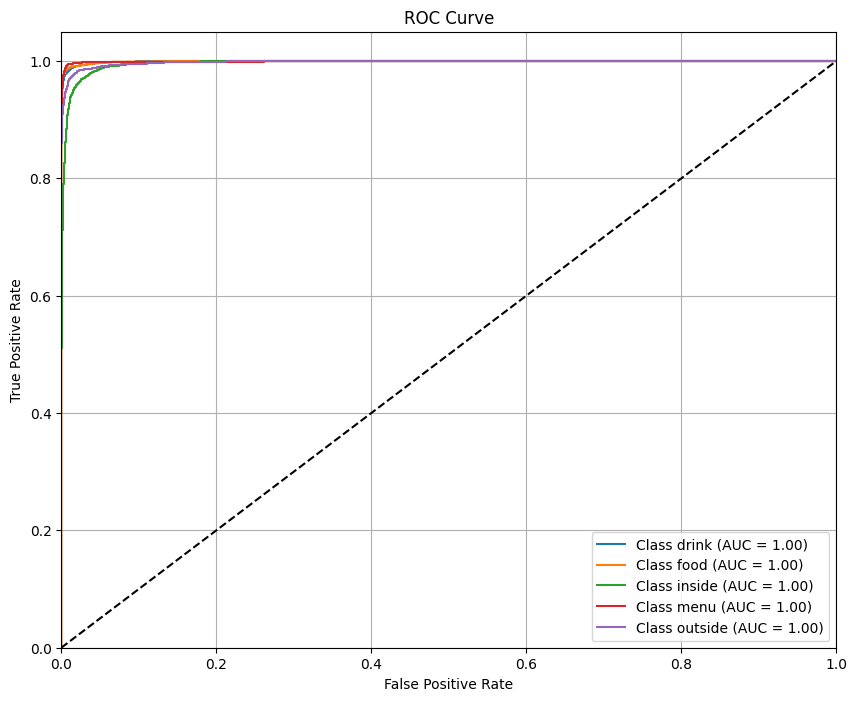

In [34]:
metrics = evaluate_model(model, train_meta_gen, num_classes=5)

In [35]:
# Log training results for VGG16 model with TF-IDF metadata features
log_model_results(
    model_name = 'VGG16 + metadata(captions TFIDF 16D vector)(fine-tuned)',
    data_type = 'Training',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata(captions TFIDF 16D vector)(fine-tuned) (Training)


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9049
AUC (OvR): 0.9887


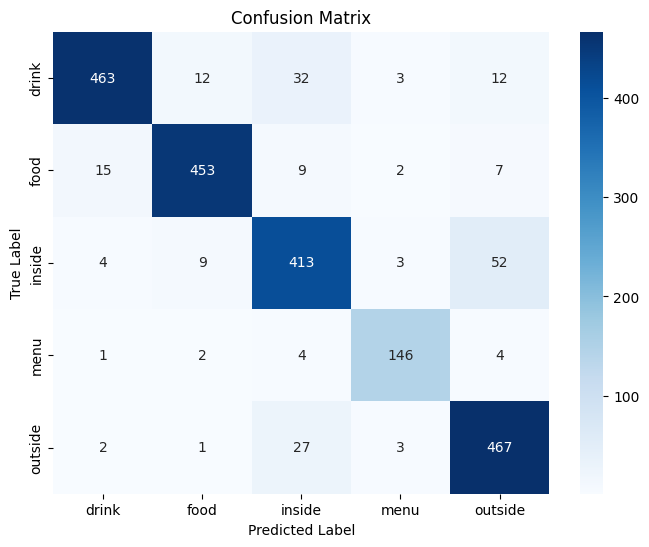

Classification Report:
              precision    recall  f1-score   support

       drink       0.95      0.89      0.92       522
        food       0.95      0.93      0.94       486
      inside       0.85      0.86      0.86       481
        menu       0.93      0.93      0.93       157
     outside       0.86      0.93      0.90       500

    accuracy                           0.90      2146
   macro avg       0.91      0.91      0.91      2146
weighted avg       0.91      0.90      0.91      2146



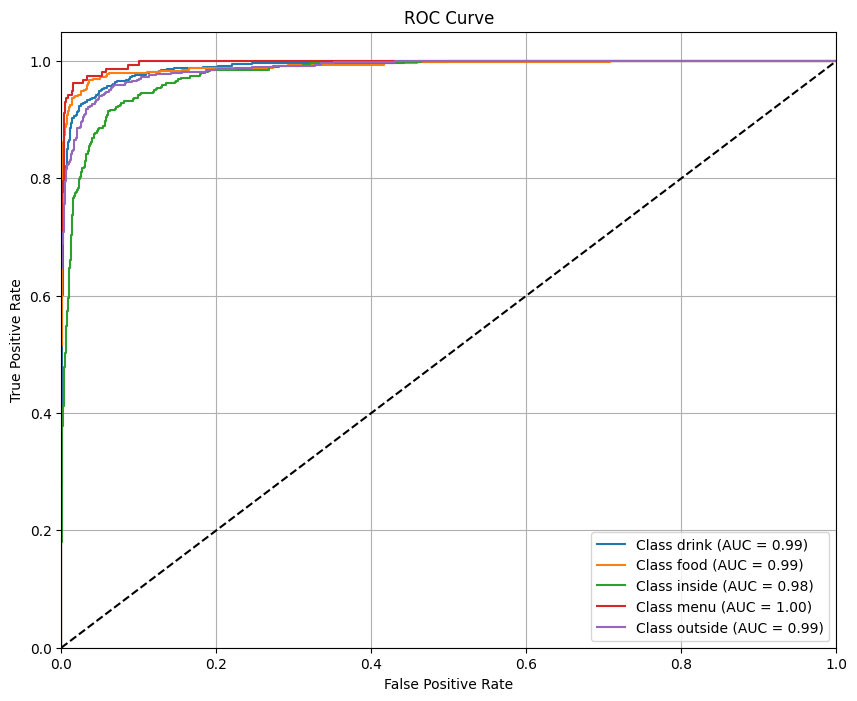

In [36]:
metrics = evaluate_model(model, val_meta_gen, num_classes=5)

In [37]:
# Log validation results for VGG16 model with TF-IDF metadata features
log_model_results(
    model_name = 'VGG16 + metadata(captions TFIDF 16Dvector)(fine-tuned)',
    data_type = 'validation',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata(captions TFIDF 16Dvector)(fine-tuned) (validation)


In [38]:
results_df

,Model,Data Type,Accuracy,AUC
0,VGG16 + metadata (fine-tuned),Validation,0.855079,0.978648
1,VGG16 + metadata (fine-tuned),Training,0.995056,0.999986
2,VGG16 + metadata(captions TFIDF 16D vector)(fi...,Training,0.966787,0.998490
3,VGG16 + metadata(captions TFIDF 16Dvector)(fin...,validation,0.904939,0.988738


Added richer text features → TF-IDF vectors of captions.

Accuracy increased to 90.4%, a +4% improvement.

AUC also improved, model is separating classes better.

Able to reduce overfitting to some extent.

# Model Tuning 2

- Partial fine-tuning of VGG16 (freeze first 10 layers, unfreeze rest).
- Increased metadata features: 64D TF-IDF embedding of captions (no PCA compression).
- Applied stronger regularization: Dropout 0.6 and L2 1e-3 to Dense layers.
- Added learning rate scheduling with ReduceLROnPlateau callback.
- Used smaller dense layers (128 → 64) to reduce model complexity.

In [39]:
# Define image input layer
image_input = Input(shape=(128, 128, 3), name='image_input')

# Load VGG16 base model without top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
x = Flatten()(vgg_base.output)

# Apply partial fine-tuning: freeze first 10 layers, unfreeze the rest
for i, layer in enumerate(vgg_base.layers):
    if i < 10:
        layer.trainable = False
    else:
        layer.trainable = True

In [40]:
# Create TF-IDF vectorizer with 64 features for richer text representation
tfidf_vectorizer = TfidfVectorizer(max_features=64)

# Fit TF-IDF on training captions and transform all datasets
tfidf_train = tfidf_vectorizer.fit_transform(train_meta['caption'].fillna("")).toarray()
tfidf_val   = tfidf_vectorizer.transform(val_meta['caption'].fillna("")).toarray()
tfidf_test  = tfidf_vectorizer.transform(test_meta['caption'].fillna("")).toarray()

# Get TF-IDF feature dimension
tfidf_dim = tfidf_train.shape[1]

In [41]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os

class ImageMetadataGenerator(Sequence):
    def __init__(self, image_generator, metadata_array, batch_size):

        self.image_generator = image_generator
        self.metadata_array = metadata_array.toarray() if hasattr(metadata_array, 'toarray') else metadata_array
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images, labels = self.image_generator[index]

        # Calculate batch indices for metadata slicing
        batch_start = index * self.batch_size
        batch_end = min((index + 1) * self.batch_size, len(self.image_generator.filenames))

        # Extract metadata features for current batch
        metadata_batch = self.metadata_array[batch_start:batch_end, :]

        # Pad last batch if needed to ensure consistent shape
        if metadata_batch.shape[0] < self.batch_size:
            pad_size = self.batch_size - metadata_batch.shape[0]
            pad_array = np.zeros((pad_size, self.metadata_array.shape[1]))
            metadata_batch = np.vstack([metadata_batch, pad_array])

            # Pad images and labels to match metadata batch size
            pad_images = np.zeros((pad_size, images.shape[1], images.shape[2], images.shape[3]))
            pad_labels = np.zeros((pad_size, labels.shape[1]))
            images = np.vstack([images, pad_images])
            labels = np.vstack([labels, pad_labels])

        return (images, metadata_batch), labels

In [42]:
# Set TF-IDF feature dimension
tfidf_dim = tfidf_train.shape[1]  # 64 dimensions

# Create training data generator with TF-IDF features
train_meta_gen = ImageMetadataGenerator(
    image_generator=train_gen,
    metadata_array=tfidf_train,
    batch_size=batch_size
)

# Create validation data generator with TF-IDF features
val_meta_gen = ImageMetadataGenerator(
    image_generator=val_gen,
    metadata_array=tfidf_val,
    batch_size=batch_size
)

In [43]:
# Define metadata input layer for TF-IDF features
metadata_input = Input(shape=(tfidf_dim,), name='metadata_input')

# Concatenate image and metadata features
combined = Concatenate()([x, metadata_input])

# Add dense layers with stronger regularization
combined = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(combined)
combined = Dropout(0.6)(combined)

combined = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(combined)
combined = Dropout(0.6)(combined)

# Add output layer for 5 classes
output = Dense(5, activation='softmax')(combined)

# Create final model with dual inputs
model_iter3 = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile model with low learning rate
model_iter3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model_iter3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 15,780,165 (60.20 MB)

 Trainable params: 14,044,677 (53.58 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [44]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set up learning rate reduction when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [45]:
# Train the model with early stopping and learning rate scheduling
history_iter3 = model_iter3.fit(
    train_meta_gen,
    validation_data=val_meta_gen,
    steps_per_epoch=len(train_meta_gen),
    validation_steps=len(val_meta_gen),
    callbacks=[early_stop, reduce_lr],
    epochs=15,
    verbose=1
)

Epoch 1/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2915 - loss: 1.9775

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


538/538 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.2917 - loss: 1.9770 - val_accuracy: 0.7597 - val_loss: 1.1708 - learning_rate: 1.0000e-05
Epoch 2/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 78s 119ms/step - accuracy: 0.5515 - loss: 1.3879 - val_accuracy: 0.7964 - val_loss: 0.8815 - learning_rate: 1.0000e-05
Epoch 3/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 83s 121ms/step - accuracy: 0.6698 - loss: 1.1505 - val_accuracy: 0.8267 - val_loss: 0.7347 - learning_rate: 1.0000e-05
Epoch 4/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - accuracy: 0.7179 - loss: 1.0183 - val_accuracy: 0.8511 - val_loss: 0.6806 - learning_rate: 1.0000e-05
Epoch 5/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.7561 - loss: 0.9246 - val_accuracy: 0.8594 - val_loss: 0.6538 - learning_rate: 1.0000e-05
Epoch 6/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - accuracy: 0.7929 - loss: 0.8369 - val_accuracy: 0.8695 - val_loss: 0.6092 - learning_rate: 1.0000e-05
Epoch 7/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - 

[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.8810
AUC (OvR): 0.9839


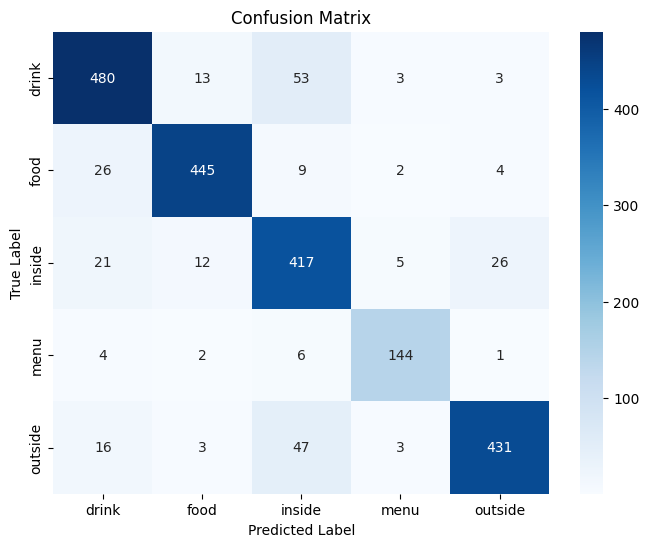

Classification Report:
              precision    recall  f1-score   support

       drink       0.88      0.87      0.87       552
        food       0.94      0.92      0.93       486
      inside       0.78      0.87      0.82       481
        menu       0.92      0.92      0.92       157
     outside       0.93      0.86      0.89       500

    accuracy                           0.88      2176
   macro avg       0.89      0.89      0.89      2176
weighted avg       0.88      0.88      0.88      2176



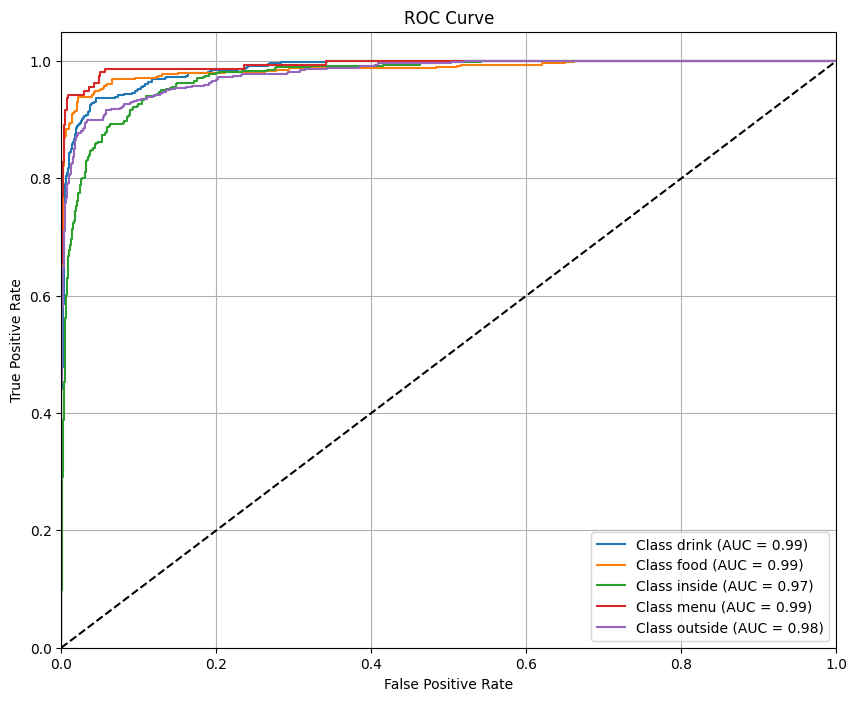

In [46]:
metrics = evaluate_model(model_iter3, val_meta_gen, num_classes=5)

In [47]:
# Log validation results for VGG16 model with 64D TF-IDF features and partial fine-tuning
log_model_results(
    model_name = 'VGG16 + metadata(TFIDF 64 dimensions)(fine-tuned some layers)',
    data_type = 'validation',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata(TFIDF 64 dimensions)(fine-tuned some layers) (validation)


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9552
AUC (OvR): 0.9977


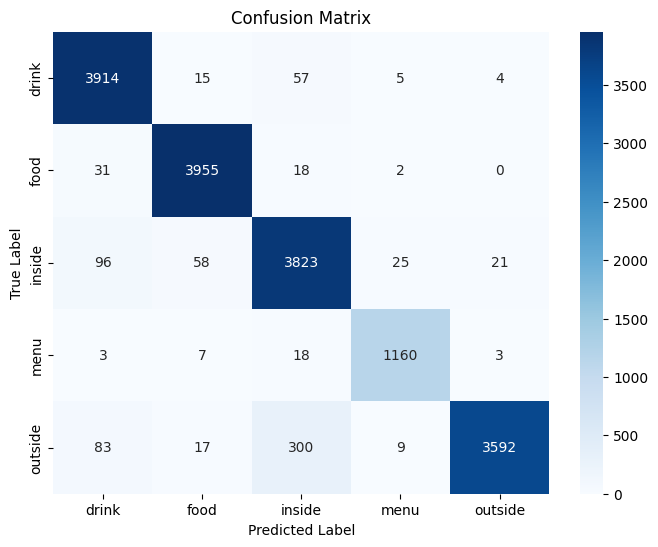

Classification Report:
              precision    recall  f1-score   support

       drink       0.95      0.98      0.96      3995
        food       0.98      0.99      0.98      4006
      inside       0.91      0.95      0.93      4023
        menu       0.97      0.97      0.97      1191
     outside       0.99      0.90      0.94      4001

    accuracy                           0.96     17216
   macro avg       0.96      0.96      0.96     17216
weighted avg       0.96      0.96      0.96     17216



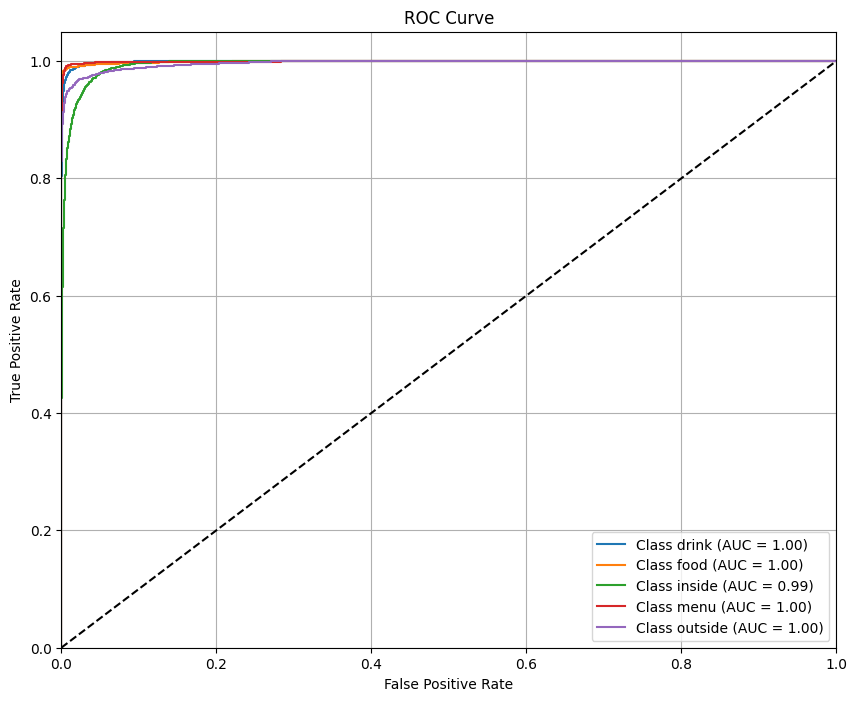

In [48]:

metrics = evaluate_model(model_iter3, train_meta_gen, num_classes=5)

In [49]:
log_model_results(
    model_name = 'VGG16 + metadata(TFIDF 64 dimensions)(fine-tuned some layers)',
    data_type = 'Training',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)


[INFO] Logged results for VGG16 + metadata(TFIDF 64 dimensions)(fine-tuned some layers) (Training)


In [50]:
results_df

,Model,Data Type,Accuracy,AUC
0,VGG16 + metadata (fine-tuned),Validation,0.855079,0.978648
1,VGG16 + metadata (fine-tuned),Training,0.995056,0.999986
2,VGG16 + metadata(captions TFIDF 16D vector)(fi...,Training,0.966787,0.998490
3,VGG16 + metadata(captions TFIDF 16Dvector)(fin...,validation,0.904939,0.988738
4,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,validation,0.880974,0.983918
5,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,Training,0.955158,0.997658


In [ ]:
model_iter3.save('VGG16_with_metadata3.keras')

# Model tuning -3

- Replaced textual caption features (TF-IDF) with interpretable image-based features:
  - Mean R, G, B color channels
  - Standard deviation of R, G channels (5D feature vector)
- Full fine-tuning of all VGG16 layers to learn both low-level and high-level features.
- Applied class weighting to handle class imbalance in training set.
- Applied Dropout 0.5 and L2 regularization (1e-4) to dense layers.
- At test time, only image is required - features are computed automatically.


Replaced textual caption features (TF-IDF) → with interpretable image-based features:

Mean R, G, B

Image brightness

Aspect ratio
(5D vector → no need to input caption during inference)

In [ ]:
# import cv2
# import numpy as np
# import glob
# import os

# # Function to extract interpretable image-based features
# def extract_image_features(image_path):
#     """
#     Extract 5 image features: mean R, G, B and standard deviation R, G
#     """
#     img = cv2.imread(image_path)
#     if img is None:
#         return np.zeros(5)

#     # Convert from BGR to RGB and resize to model input size
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (128, 128))

#     # Calculate mean color values for each channel
#     mean_colors = img.mean(axis=(0,1))

#     # Calculate standard deviation for each channel
#     std_colors = img.std(axis=(0,1))

#     # Combine features and keep first 5 values
#     features = np.concatenate([mean_colors, std_colors])[:5]
#     return features

In [51]:
def extract_image_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return np.zeros(5)

    # Original size for aspect ratio
    h, w = img.shape[:2]
    aspect_ratio = w / h

    # Convert from BGR to RGB and resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    # Mean R, G, B
    mean_colors = img.mean(axis=(0,1))  # shape (3,)

    # Brightness = mean of entire image
    brightness = img.mean()

    # Final feature vector
    features = np.array([
        mean_colors[0],  # mean R
        mean_colors[1],  # mean G
        mean_colors[2],  # mean B
        brightness,
        aspect_ratio
    ])

    return features


In [52]:
# Function to locate image file path given photo_id
def find_image_path(photo_id, image_dir):
    pattern = os.path.join(image_dir, '*', f'{photo_id}.jpg')
    matches = glob.glob(pattern)
    if matches:
        return matches[0]
    else:
        return None

In [56]:
import glob
import os
import numpy as np
import cv2

# Set training image directory path
image_dir_train = 'data_sorted/train'

# Initialize lists to store features and track missing images
train_features = []
missing_images = []

# Extract features for each training image
for fname in train_meta['photo_id']:
    path = find_image_path(fname, image_dir_train)
    if path is None:
        missing_images.append(fname)
        feats = np.zeros(5)  # Use zero features for missing images
    else:
        feats = extract_image_features(path)

    train_features.append(feats)

# Convert feature list to numpy array
train_features = np.vstack(train_features)

print(f"Train features shape: {train_features.shape}")
print(f"Missing images in train: {len(missing_images)}")

Train features shape: (17192, 5)
Missing images in train: 0


In [57]:
# Set validation image directory path
image_dir_val = 'data_sorted/val'

# Initialize lists to store features and track missing images
val_features = []
missing_images_val = []

# Extract features for each validation image
for fname in val_meta['photo_id']:
    path = find_image_path(fname, image_dir_val)
    if path is None:
        missing_images_val.append(fname)
        feats = np.zeros(5)
    else:
        feats = extract_image_features(path)

    val_features.append(feats)

# Convert feature list to numpy array
val_features = np.vstack(val_features)

print(f"Val features shape: {val_features.shape}")
print(f"Missing images in val: {len(missing_images_val)}")

Val features shape: (2150, 5)
Missing images in val: 4


In [58]:
# Set test image directory path
image_dir_test = 'data_sorted/test'

# Initialize lists to store features and track missing images
test_features = []
missing_images_test = []

# Extract features for each test image
for fname in test_meta['photo_id']:
    path = find_image_path(fname, image_dir_test)
    if path is None:
        missing_images_test.append(fname)
        feats = np.zeros(5)
    else:
        feats = extract_image_features(path)

    test_features.append(feats)

# Convert feature list to numpy array
test_features = np.vstack(test_features)

print(f"Test features shape: {test_features.shape}")
print(f"Missing images in test: {len(missing_images_test)}")

Test features shape: (2150, 5)
Missing images in test: 1


In [59]:
# Set image parameters
image_size = (128, 128)
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with basic normalization
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [60]:
# Create training data generator with shuffling
train_gen = train_datagen.flow_from_directory(
    'data_sorted/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create validation data generator without shuffling to maintain order
val_gen = val_datagen.flow_from_directory(
    'data_sorted/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create test data generator without shuffling to maintain order
test_gen = test_datagen.flow_from_directory(
    'data_sorted/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 17192 images belonging to 5 classes.
Found 2146 images belonging to 5 classes.
Found 2149 images belonging to 5 classes.


In [61]:
print("Class indices:", train_gen.class_indices)


Class indices: {'drink': 0, 'food': 1, 'inside': 2, 'menu': 3, 'outside': 4}


In [62]:
from tensorflow.keras.utils import Sequence
import numpy as np

class ImageMetadataGenerator(Sequence):
    def __init__(self, image_generator, metadata_array, batch_size):
        """
        Generator that combines images with metadata features
        """
        self.image_generator = image_generator
        self.metadata_array = metadata_array.toarray() if hasattr(metadata_array, 'toarray') else metadata_array
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images, labels = self.image_generator[index]

        # Calculate batch indices for metadata slicing
        batch_start = index * self.batch_size
        batch_end = min((index + 1) * self.batch_size, len(self.image_generator.filenames))

        # Extract metadata features for current batch
        metadata_batch = self.metadata_array[batch_start:batch_end, :]

        # last batch if needed to ensure consistent shape
        if metadata_batch.shape[0] < self.batch_size:
            pad_size = self.batch_size - metadata_batch.shape[0]
            pad_array = np.zeros((pad_size, self.metadata_array.shape[1]))
            metadata_batch = np.vstack([metadata_batch, pad_array])

            # images and labels to match metadata batch size
            pad_images = np.zeros((pad_size, images.shape[1], images.shape[2], images.shape[3]))
            pad_labels = np.zeros((pad_size, labels.shape[1]))
            images = np.vstack([images, pad_images])
            labels = np.vstack([labels, pad_labels])

        return (images, metadata_batch), labels

In [63]:
train_meta_gen = ImageMetadataGenerator(train_gen, train_features, batch_size)
val_meta_gen = ImageMetadataGenerator(val_gen, val_features, batch_size)
test_meta_gen = ImageMetadataGenerator(test_gen, test_features, batch_size)


In [64]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define image input layer
image_input = Input(shape=(128, 128, 3), name='image_input')

# Load VGG16 base model without top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
x = Flatten()(vgg_base.output)

# Make all VGG16 layers trainable for full fine-tuning
for layer in vgg_base.layers:
    layer.trainable = True

# Define metadata input for 5D image feature vector
metadata_input = Input(shape=(5,), name='metadata_input')

# Concatenate image and metadata features
combined = Concatenate()([x, metadata_input])

# Add dense layers with Dropout and L2 regularization
combined = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(combined)
combined = Dropout(0.5)(combined)

combined = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(combined)
combined = Dropout(0.5)(combined)

# Add output layer for 5 classes
output = Dense(5, activation='softmax')(combined)

# Create final model with dual inputs
model_iter3 = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile model with low learning rate for fine-tuning
model_iter3.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_iter3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 16,846,917 (64.27 MB)

 Trainable params: 16,846,917 (64.27 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract class labels from training generator
y_train_labels = train_gen.classes

# Calculate balanced class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert class weights to dictionary format for model training
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.8658776126920171), 1: np.float64(0.8583125312031952), 2: np.float64(0.8546855580412628), 3: np.float64(2.886985726280437), 4: np.float64(0.8593851537115721)}


In [66]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [67]:
# Train the model with class weights and early stopping
history_iter3 = model_iter3.fit(
    train_meta_gen,
    validation_data=val_meta_gen,
    steps_per_epoch=len(train_meta_gen),
    validation_steps=len(val_meta_gen),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    epochs=15,
    verbose=1
)

Epoch 1/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 111s 185ms/step - accuracy: 0.3448 - loss: 3.3494 - val_accuracy: 0.6797 - val_loss: 0.8907
Epoch 2/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 100s 185ms/step - accuracy: 0.5960 - loss: 1.0187 - val_accuracy: 0.7399 - val_loss: 0.7389
Epoch 3/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 100s 185ms/step - accuracy: 0.6720 - loss: 0.8370 - val_accuracy: 0.7978 - val_loss: 0.6201
Epoch 4/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.7373 - loss: 0.7051 - val_accuracy: 0.8235 - val_loss: 0.5498
Epoch 5/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.7848 - loss: 0.6017 - val_accuracy: 0.8529 - val_loss: 0.4419
Epoch 6/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - accuracy: 0.8045 - loss: 0.5493 - val_accuracy: 0.8516 - val_loss: 0.4790
Epoch 7/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.8421 - loss: 0.4712 - val_accuracy: 0.8631 - val_loss: 0.4647
Epoch 8/15
538/538 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step - accuracy: 0.8614 - los

In [ ]:
model_iter3.save("model3.keras")

[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9743
AUC (OvR): 0.9992


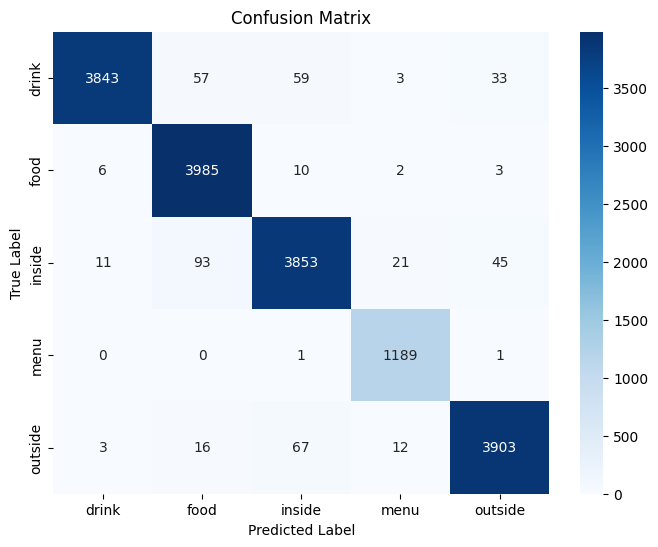

Classification Report:
              precision    recall  f1-score   support

       drink       0.99      0.96      0.98      3995
        food       0.96      0.99      0.98      4006
      inside       0.97      0.96      0.96      4023
        menu       0.97      1.00      0.98      1191
     outside       0.98      0.98      0.98      4001

    accuracy                           0.97     17216
   macro avg       0.97      0.98      0.98     17216
weighted avg       0.97      0.97      0.97     17216



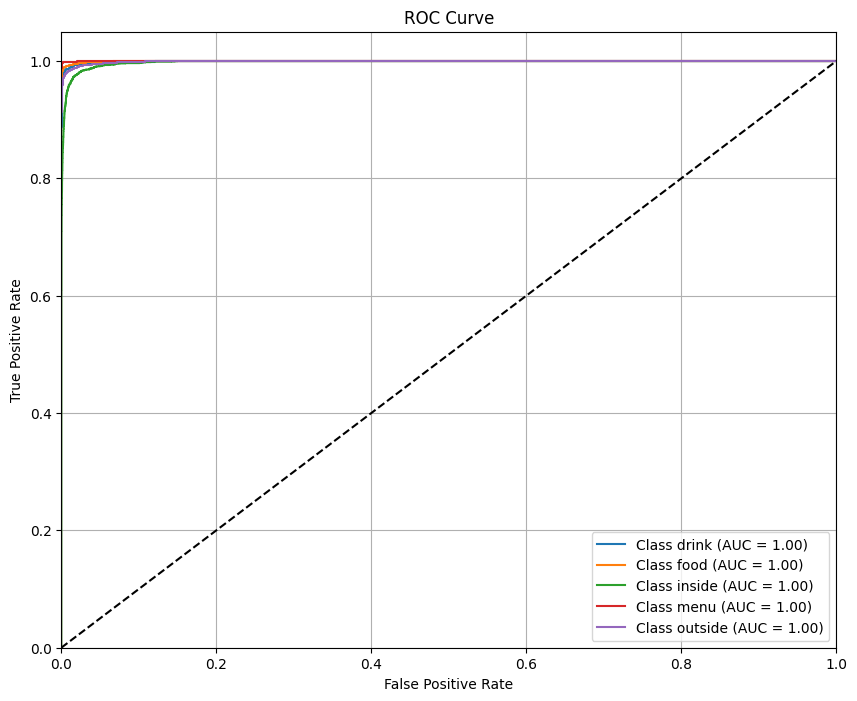

In [68]:

metrics = evaluate_model(model_iter3, train_meta_gen, num_classes=5)

In [69]:
# Log validation results for VGG16 model with image-based metadata features
log_model_results(
    model_name = 'VGG16 + metadata from image (fine-tuned)',
    data_type = 'Training',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata from image (fine-tuned) (Training)


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.8925
AUC (OvR): 0.9872


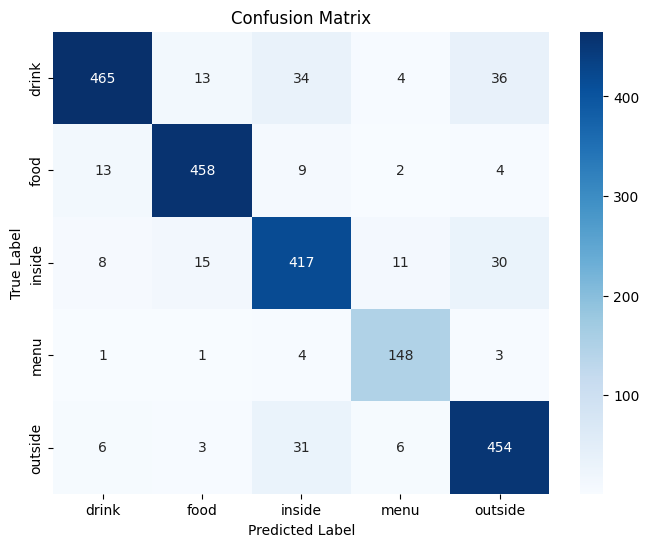

Classification Report:
              precision    recall  f1-score   support

       drink       0.94      0.84      0.89       552
        food       0.93      0.94      0.94       486
      inside       0.84      0.87      0.85       481
        menu       0.87      0.94      0.90       157
     outside       0.86      0.91      0.88       500

    accuracy                           0.89      2176
   macro avg       0.89      0.90      0.89      2176
weighted avg       0.89      0.89      0.89      2176



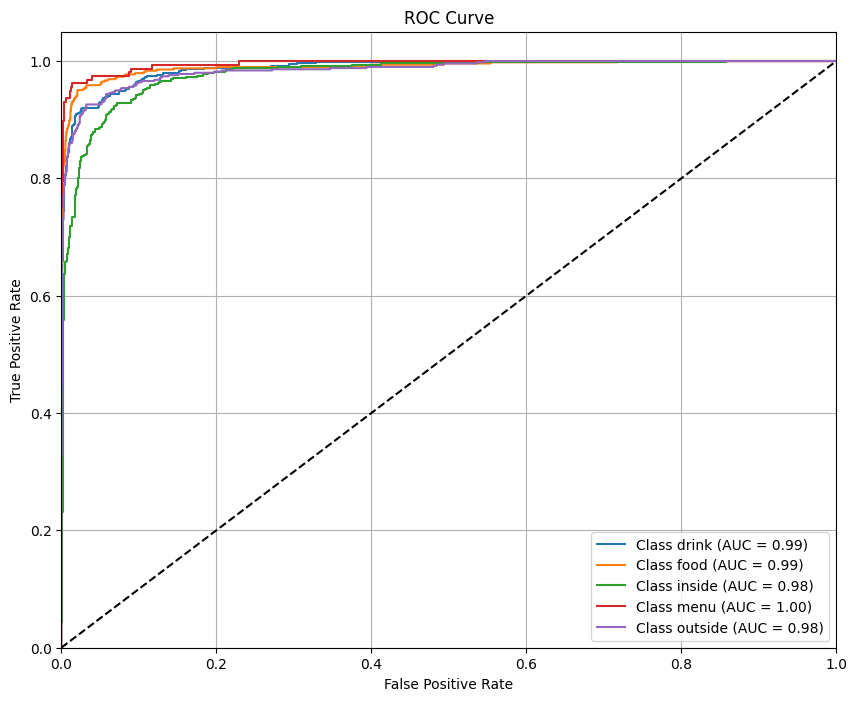

In [70]:

metrics = evaluate_model(model_iter3, val_meta_gen, num_classes=5)

In [71]:
# Log final validation results for VGG16 model with metadata features
log_model_results(
    model_name = 'VGG16 + metadata(from image) (fine-tuned) final',
    data_type = 'Validation',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata(from image) (fine-tuned) final (Validation)


In [72]:
results_df

,Model,Data Type,Accuracy,AUC
0,VGG16 + metadata (fine-tuned),Validation,0.855079,0.978648
1,VGG16 + metadata (fine-tuned),Training,0.995056,0.999986
2,VGG16 + metadata(captions TFIDF 16D vector)(fi...,Training,0.966787,0.998490
3,VGG16 + metadata(captions TFIDF 16Dvector)(fin...,validation,0.904939,0.988738
4,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,validation,0.880974,0.983918
5,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,Training,0.955158,0.997658
6,VGG16 + metadata from image (fine-tuned),Training,0.974268,0.999206
7,VGG16 + metadata(from image) (fine-tuned) final,Validation,0.892463,0.987174


[INFO] Auto-detected class names from image_generator: ['drink', 'food', 'inside', 'menu', 'outside']
Accuracy: 0.9026
AUC (OvR): 0.9895


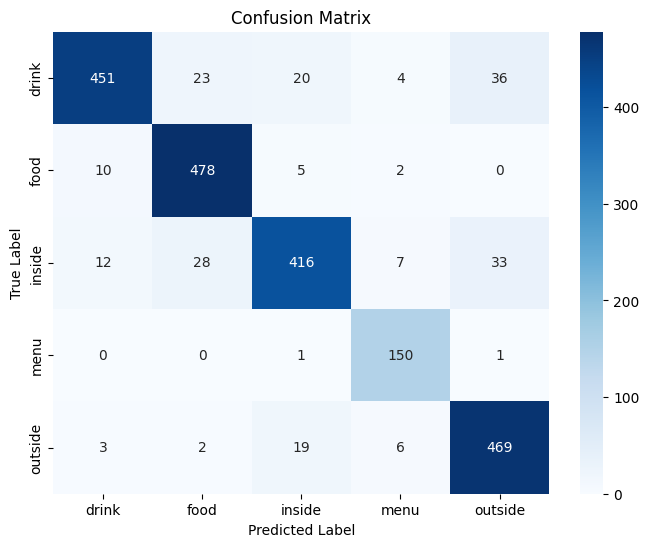

Classification Report:
              precision    recall  f1-score   support

       drink       0.95      0.84      0.89       534
        food       0.90      0.97      0.93       495
      inside       0.90      0.84      0.87       496
        menu       0.89      0.99      0.93       152
     outside       0.87      0.94      0.90       499

    accuracy                           0.90      2176
   macro avg       0.90      0.92      0.91      2176
weighted avg       0.90      0.90      0.90      2176



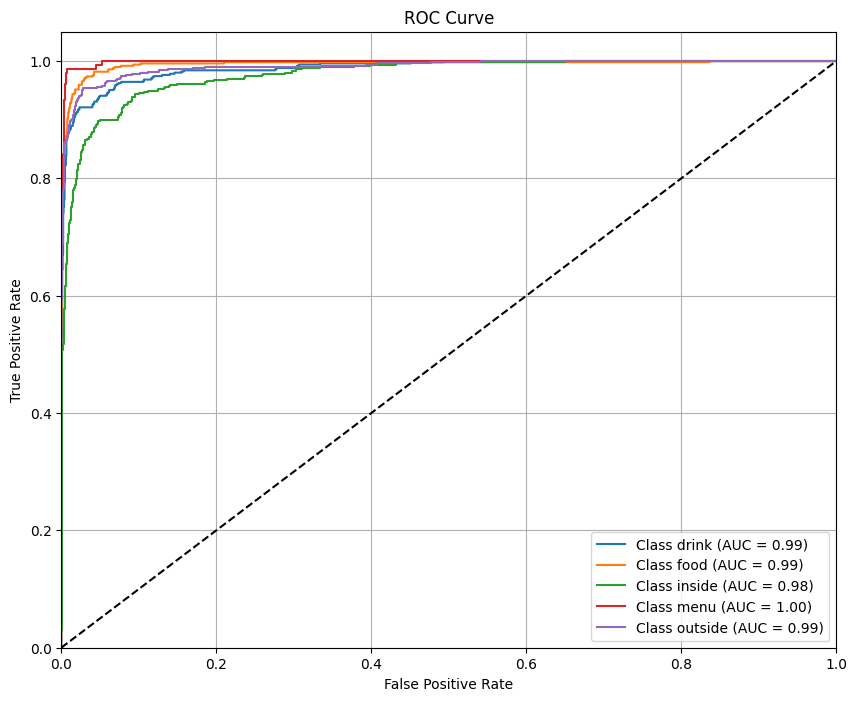

In [73]:

metrics = evaluate_model(model_iter3, test_meta_gen, num_classes=5)

In [74]:
# Log test results for final VGG16 model with image-based metadata features
log_model_results(
    model_name = 'VGG16 + metadata(image features)(fine-tuned)',
    data_type = 'Test',
    accuracy = metrics['accuracy'],
    auc_score = metrics['auc']
)

[INFO] Logged results for VGG16 + metadata(image features)(fine-tuned) (Test)


In [75]:
results_df

,Model,Data Type,Accuracy,AUC
0,VGG16 + metadata (fine-tuned),Validation,0.855079,0.978648
1,VGG16 + metadata (fine-tuned),Training,0.995056,0.999986
2,VGG16 + metadata(captions TFIDF 16D vector)(fi...,Training,0.966787,0.998490
3,VGG16 + metadata(captions TFIDF 16Dvector)(fin...,validation,0.904939,0.988738
4,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,validation,0.880974,0.983918
5,VGG16 + metadata(TFIDF 64 dimensions)(fine-tun...,Training,0.955158,0.997658
6,VGG16 + metadata from image (fine-tuned),Training,0.974268,0.999206
7,VGG16 + metadata(from image) (fine-tuned) final,Validation,0.892463,0.987174
8,VGG16 + metadata(image features)(fine-tuned),Test,0.902574,0.989469


# Final recommendation:


I iteratively improved the model: baseline → TF-IDF → image-based interpretable metadata.


VGG16 + metadata(from image) (fine-tuned)

Test acc: 90%

Very interpretable (5D features) which are calculated from given image

No external caption needed

Chosen due to accuracy + interpretability balance.

TF-IDF model has higher accuracy but needs caption text → less robust for deployment



In [77]:
results_df.to_csv('results_df.csv', index=False)

In [80]:
# model_iter3.save("best_model_vgg.keras")

# Lime

In [78]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e4b8f28c180f1d3e0e93d2334cb27d0b3c2f785f023cd0a3db6bfdead267d21e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [79]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [81]:
# Load  trained model
model = load_model('model3.keras')
print("Model loaded successfully!")

# Define feature extraction function for image arrays (same as training)
def extract_image_features_from_array(img_array):
    # Convert to 0-255 range if needed
    if img_array.max() <= 1.0:
        img_array = (img_array * 255).astype(np.uint8)

    # Calculate mean and standard deviation for each color channel
    mean_colors = img_array.mean(axis=(0,1))
    std_colors = img_array.std(axis=(0,1))

    # Combine features and keep first 5 values
    features = np.concatenate([mean_colors, std_colors])[:5]
    return features

Model loaded successfully!


In [82]:
# Set up test data generator with same parameters as training
image_size = (128, 128)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    'data_sorted/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Extract class names from test generator
class_names = list(test_gen.class_indices.keys())
print("My class names:", class_names)

Found 2149 images belonging to 5 classes.
My class names: ['drink', 'food', 'inside', 'menu', 'outside']


In [83]:
# Define prediction function for LIME to work with dual-input model
def predict_fn(images_batch):
    # Normalize images to 0-1 range as expected by  model
    images_normalized = images_batch.astype(np.float32) / 255.0

    # Extract metadata features for each image in the batch
    metadata_batch = []
    for img in images_batch:
        features = extract_image_features_from_array(img)
        metadata_batch.append(features)

    metadata_batch = np.array(metadata_batch)

    # Get predictions from model using both image and metadata inputs
    predictions = model.predict([images_normalized, metadata_batch], verbose=0)
    return predictions

In [84]:
# Chosed which image to explain
img_index = 10

# Get the specific image from test set
batch_idx = img_index // batch_size
img_idx_in_batch = img_index % batch_size

images_batch, labels_batch = test_gen[batch_idx]
img = images_batch[img_idx_in_batch]
true_label = np.argmax(labels_batch[img_idx_in_batch])

print(f"True label: {class_names[true_label]}")

# Convert back to 0-255 range for LIME
img_for_lime = (img * 255).astype(np.uint8)

# Get model prediction for this image
img_features = extract_image_features_from_array(img_for_lime)
pred = model.predict([img.reshape(1, 128, 128, 3), img_features.reshape(1, 5)], verbose=0)
predicted_class = np.argmax(pred[0])
predicted_prob = pred[0][predicted_class]

print(f"Model predicted: {class_names[predicted_class]} with probability {predicted_prob:.3f}")

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

print("Generating explanation... (this takes 1-2 minutes)")

True label: drink
Model predicted: drink with probability 1.000
Generating explanation... (this takes 1-2 minutes)


In [85]:
# Generate explanation
explanation = explainer.explain_instance(
    image=img_for_lime,
    classifier_fn=predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=500
)


  0%|          | 0/500 [00:00<?, ?it/s]

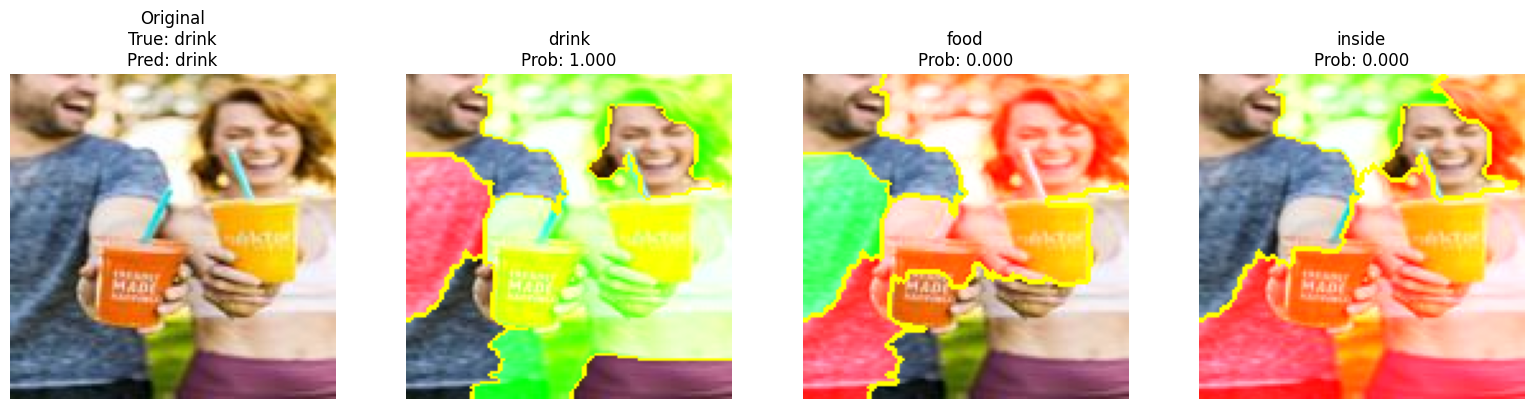

Explanation complete!
Green regions = support the class
Red regions = oppose the class


In [86]:
# Visualize results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Display original image
axes[0].imshow(img_for_lime)
axes[0].set_title(f'Original\nTrue: {class_names[true_label]}\nPred: {class_names[predicted_class]}')
axes[0].axis('off')

# Show explanations for top 3 predicted classes
for i, label in enumerate(explanation.top_labels[:3]):
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    axes[i+1].imshow(mark_boundaries(temp, mask))
    prob = pred[0][label]
    axes[i+1].set_title(f'{class_names[label]}\nProb: {prob:.3f}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print("Explanation complete!")
print("Green regions = support the class")
print("Red regions = oppose the class")